# Tutorial: Simple Implementation

This is the most basic tutorial and its concern on demonstrate a simple use of OHRP, HR, RP and EW as well as present the reader with the basics of visualizing a weight vector distibution.

By Kevin Pergher, December the 24th, 2025.

In [ ]:
import pandas
import datetime
import warnings

warnings.filterwarnings("ignore")

# Call our libraries
from OHRP import OHRP
from HRP import HRP
from RP import RP
from EW import EW

# Extract the dataset
Xn = pandas.read_csv('datasets/IBOV_equity_closing_prices.csv', index_col = 0)
Xn.index = pandas.to_datetime(Xn.index, format='%Y-%m-%d')

WL = 252

# Prepare the dataset
Xn.dropna(axis = 0, how = 'all', inplace = True)
Xn.dropna(axis = 1, thresh = int(0.9 * WL), inplace = True)
Xn = Xn.pct_change().fillna(0)
Xn = Xn.iloc[-WL:, :]
# Using a subset of assets for faster computation
Xn = Xn[['PETR4', 'ITUB4', 'VALE3', 'BBAS3', 'WEGE3']]

# ORTHOGONAL HRP (OHRP)
ohrp = OHRP(codep = "pearson", linkage = "ward")
weightsOHRP = ohrp.run(
    X = Xn.copy(), 
    k = [1,3,5,7,9,11,13], 
    d = [5,10,15,20,25,30,35], 
    r = [0.9]
)
weightsOHRP.name = 'OHRP'
print(weightsOHRP)

# HIERARCHICAL RISK PARITY (HRP)
hrp = HRP(codep = "pearson", linkage = "ward")
weightsHRP = hrp.run(
    X = Xn.copy()
)
weightsHRP.name = 'HRP'
print(weightsHRP)

# RISK PARITY (RP)
rp = RP(method_cov="ledoit")
weightsRP = rp.run(
    X = Xn.copy()
)
weightsRP.name = 'RP'
print(weightsRP)

# EQUAL WEIGHT (EW)
ew = EW()
weightsEW = ew.run(
    X = Xn.copy()
)
weightsEW.name = 'EW'
print(weightsEW)

PETR4    0.074854
ITUB4    0.692650
VALE3    0.050684
BBAS3    0.170854
WEGE3    0.010958
Name: OHRP, dtype: float64
PETR4    0.256957
ITUB4    0.264244
VALE3    0.199539
BBAS3    0.160609
WEGE3    0.118652
Name: HRP, dtype: float64
PETR4    0.211895
ITUB4    0.210630
VALE3    0.209958
BBAS3    0.186768
WEGE3    0.180749
Name: RP, dtype: float64
PETR4    0.2
ITUB4    0.2
VALE3    0.2
BBAS3    0.2
WEGE3    0.2
Name: EW, dtype: float64


Plotting a pizza plot - The area indicates how much weight each asset have on the whole weight vector

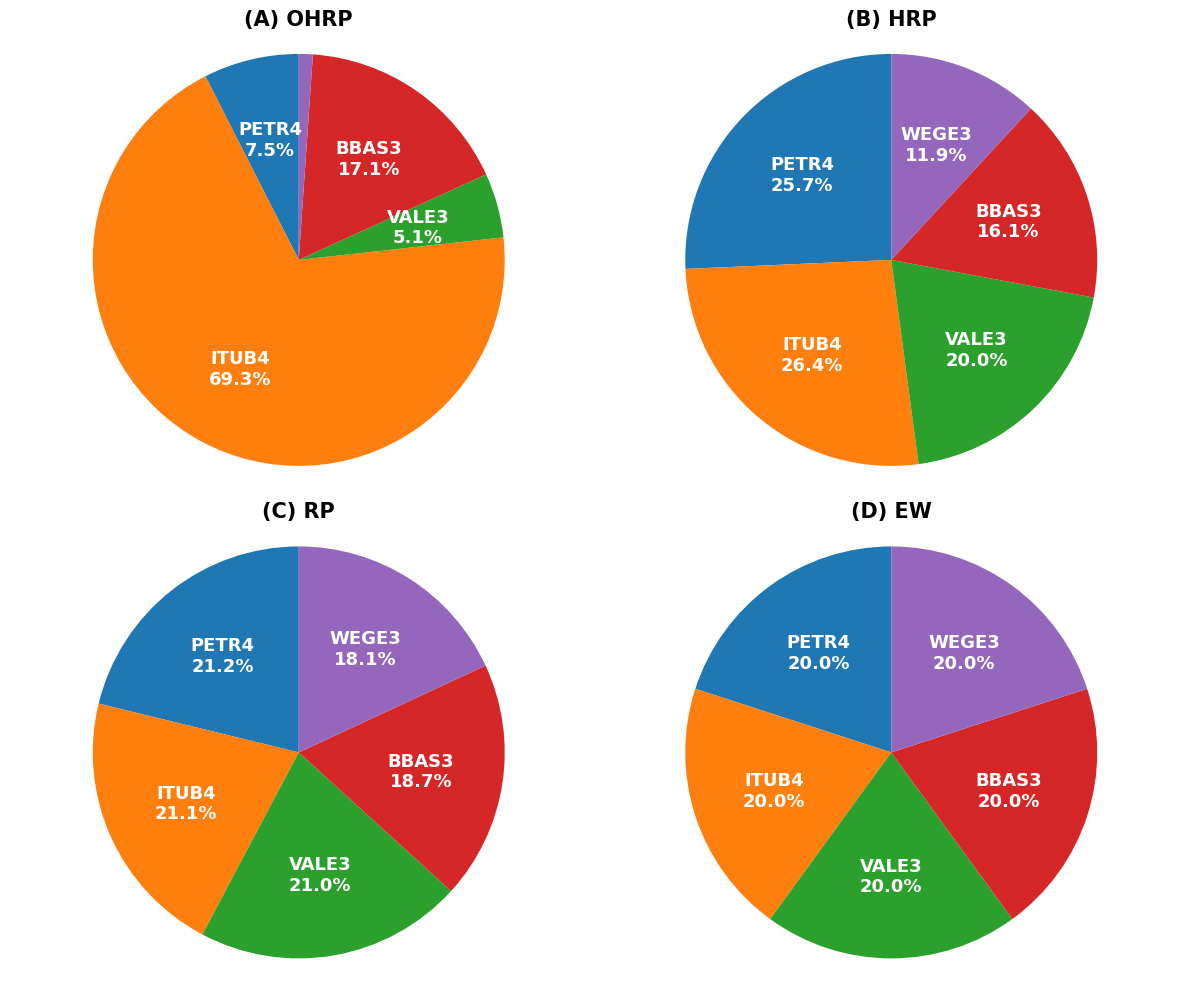

In [2]:
import matplotlib.pyplot as plt
import numpy

def plot_pizza_4(s1, s2, s3, s4):
    """
    2x2 pizza plots. Label rules:
      - >7%: name + % inside (white, bold).
      - 2%–7%: percentage shown near wedge and name placed outside on the RIGHT with connector.
      - <2%: no label (only color).
    Keeps matplotlib's original pie colors.
    """
    series_list = [s1, s2, s3, s4]
    labels = ['(A)', '(B)', '(C)', '(D)']

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, (s, ax) in enumerate(zip(series_list, axes)):
        # Percentages
        s_perc = s / s.sum() * 100

        # Draw pie WITHOUT labels so colors remain default
        wedges, texts, autotexts = ax.pie(
            s_perc,
            labels=None,
            autopct='%1.1f%%',    # autotexts will be adjusted/cleared later
            startangle=90,
            textprops={'fontsize': 11, 'weight': 'bold'}
        )

        # remove default label objects in 'texts'
        for txt in texts:
            txt.set_text("")

        ax.set_title(f"{labels[i]} {s.name}", fontsize=15, fontweight='bold')
        ax.axis('equal')

        # track used y positions on right to slightly stack outside labels and avoid overlap
        right_y_positions = []

        for j, (wedge, at) in enumerate(zip(wedges, autotexts)):
            pct = float(s_perc.iloc[j])
            name = str(s.index[j])

            # center angle of wedge (degrees)
            ang = (wedge.theta2 + wedge.theta1) / 2.0
            # unit vector pointing to wedge center
            ux = numpy.cos(numpy.deg2rad(ang))
            uy = numpy.sin(numpy.deg2rad(ang))

            if pct > 5:
                # inside label
                at.set_text(f"{name}\n{pct:.1f}%")
                at.set_color('white')
                at.set_fontsize(13)
                at.set_fontweight('bold')

            elif pct >= 2:
                # show percent near wedge but put name on the RIGHT of the circle
                at.set_text(f"{pct:.1f}%")
                at.set_color('black')
                at.set_fontsize(11)

                # base right-side coords
                rx = 1.25  # fixed right x (outside circle)
                ry = uy * 0.9  # start at radial y, scaled inside range [-0.9,0.9]

                # if the wedge is already on the right side, keep a radial-like y;
                # if wedge is on the left, mirror x to RIGHT and keep same y sign
                # (so labels are always on the right)
                # Slightly adjust y to avoid overlapping many labels at identical y:
                # find the closest free y near ry
                def find_free_y(target_y, used, delta=0.06):
                    # try offsets 0, ±delta, ±2*delta, ...
                    for k in range(0, 20):
                        for sign in (1, -1):
                            cand = target_y + sign * k * delta
                            # keep within [-1.2, 1.2] to not escape figure
                            if cand < -1.2 or cand > 1.2:
                                continue
                            # accept if not too close to existing ones
                            if all(abs(cand - u) > 0.05 for u in used):
                                return cand
                    return target_y  # fallback

                ry = find_free_y(ry, right_y_positions)
                right_y_positions.append(ry)

                # place name at right side (rx, ry), percentage near wedge with small connector line
                ax.text(rx, ry, name, ha='left', va='center', fontsize=11, fontweight='bold')

                # draw connector line from wedge edge to the label
                # line start: a point a bit outside the wedge (~0.95 radius), line end: a bit left of label
                start_x = 0.95 * ux
                start_y = 0.95 * uy
                end_x = rx - 0.05  # small gap before label
                end_y = ry
                ax.plot([start_x, end_x], [start_y, end_y], color='gray', lw=1.0)

                # optionally move the percent text a bit inside along the wedge radius
                at_x = 0.6 * ux
                at_y = 0.6 * uy
                at.set_x(at_x)
                at.set_y(at_y)

            else:
                # <2% : no label (only colored slice). clear the autotext
                at.set_text("")

    plt.tight_layout()
    plt.show()

plot_pizza_4(weightsOHRP, weightsHRP, weightsRP, weightsEW)